# Pytorch CIFAR100 Denoising

Based on: 
- [Guide by Maxim Artemev](https://nbviewer.jupyter.org/github/MaximArtemev/hse_gans/blob/master/seminars/seminar-1/1.pytorch-homework.ipynb)
- [DnCNN Paper](https://arxiv.org/abs/1608.03981)

### Results

[All experiments](https://www.comet.ml/topilskiyak/fastrino)

| std | test_mse, $10^{-3}$ | link |
| --- | ------------------- | ---- |
| 0.1 |                 3.6 | [std=0.1](https://www.comet.ml/topilskiyak/fastrino/43b7174fe08e4057a2b4ce3721b0ca96) |
| 0.2 | 9.3 | [std=0.2](https://www.comet.ml/topilskiyak/fastrino/43b7174fe08e4057a2b4ce3721b0ca96) |
| 0.4 | 24 | [std=0.4](https://www.comet.ml/topilskiyak/fastrino/8328340b0c414431a30a2a978adc820e) |
| 0.8 | 56 | [std=0.8](https://www.comet.ml/topilskiyak/fastrino/d5e3c263d9fb4397a95f2920662b7f82) |



In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import numpy as np

In [0]:
test_mse = {
    0.1: 0.0035804091463502072,
    0.2: 0.009282774126888075,
    0.4: 0.02377412248921545,
    0.8: 0.05551912192302414,
}

xs = np.array(list(test_mse.keys()))
ys = - np.log10(np.asarray(list(test_mse.values())))

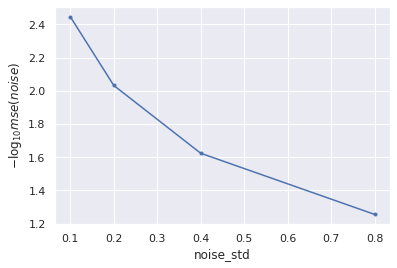

In [3]:
plt.plot(xs, ys, marker=".")
plt.xlabel("noise_std")
plt.ylabel("$-\log_{10} mse(noise)$")
plt.show()

### Comet_ML

NOTE: comet_ml is not installed in google colab by default

In [0]:
#!pip install comet_ml

In [0]:
comet_ml_settings = dict(
    api_key=None,
    project_name="fastrino",
    workspace=None,
)

assert comet_ml_settings["api_key"] is not None, "set your comet_ml api_key"
assert comet_ml_settings["workspace"] is not None, "set your comet_ml workspace"

In [0]:
from comet_ml import Experiment

### Import

In [0]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm_notebook

import torch
import torch.functional as F
from torch import nn
from torch.utils.data.dataset import Dataset

import torchvision
from torchvision import transforms

device = 'cuda'

### Data

In [0]:
# [0, 1] -> [-1, 1]
transform = transforms.Compose([
     transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.25, 0.25, 0.25))
])

In [6]:
data_path = './cifar100-data'
classification_train_set = torchvision.datasets.CIFAR100(
    root=data_path, train=True, download=True, transform=transform)
classification_test_set = torchvision.datasets.CIFAR100(
    root=data_path, train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [0]:
class DenoisingDataset(Dataset):
    def __init__(self, dataset, noise_std):
        self.dataset = dataset
        self.noise_std = noise_std
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        image, _ = self.dataset[index]
        noise = self.noise_std * torch.randn_like(image)
        noisy_image = image + noise
        return noisy_image, noise

def get_denoising_train_test(noise_std):
    train_set = DenoisingDataset(classification_train_set, noise_std)
    test_set = DenoisingDataset(classification_test_set, noise_std)
    return train_set, test_set

In [0]:
def get_denoising_train_test_loaders(noise_std, batch_size):
    train_set, test_set = get_denoising_train_test(noise_std)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=dummy_batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=dummy_batch_size, shuffle=False)
    
    return train_loader, test_loader

In [9]:
dummy_batch_size = 128
dummy_train_loader, dummy_test_loader = get_denoising_train_test_loaders(0.1, 128)

dummy_batch_image, dummy_batch_target = next(iter(dummy_train_loader))
print(dummy_batch_image.shape)
print(dummy_batch_target.shape)
print(f"std={dummy_batch_target.std()}")

torch.Size([128, 3, 32, 32])
torch.Size([128, 3, 32, 32])
std=0.09993846714496613


### Model

In [0]:
class Block(nn.Module):
    def __init__(self, in_, out):
        super(Block, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_, out, kernel_size=3, padding=1),
            nn.BatchNorm2d(out),
            nn.ReLU(),
        )
    
    def forward(self, x):
        return self.block(x)

class DnCNN(nn.Module):
    def __init__(self, num_blocks=4, input_image_shape=[3, 32, 32], block_num_filters=64):
        super(DnCNN, self).__init__()
        num_input_channels, *_ = input_image_shape

        self.input_convrelu = nn.Sequential(
            nn.Conv2d(num_input_channels, block_num_filters, kernel_size=3, padding=1),
            nn.ReLU(),
        )

        blocks = [Block(block_num_filters, block_num_filters) for _ in range(num_blocks)]
        self.blocks = nn.Sequential(*blocks)

        self.output_conv = nn.Conv2d(block_num_filters, num_input_channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        input_ = self.input_convrelu(x)
        blocks = self.blocks(input_)
        output = self.output_conv(blocks)
        return output

In [0]:
def get_model():
    model = DnCNN().to(device)
    return model

### Loss and Optimizer

In [0]:
def get_criterion():
    criterion = nn.MSELoss()
    return criterion

def get_optimizer(model):
    optimizer = torch.optim.Adam(model.parameters())
    return optimizer

### Training

In [0]:
def train(noise_std=0.1, batch_size=128, num_epochs=10):
    train_loader, test_loader = get_denoising_train_test_loaders(noise_std, batch_size)

    model = get_model()
    criterion = get_criterion()
    optimizer = get_optimizer(model)

    experiment = Experiment(**comet_ml_settings)

    for epoch in tqdm_notebook(range(num_epochs), desc='Epoch loop'):
        with experiment.train():
            model.train()

            tqdm_notebook_train = tqdm_notebook(
                train_loader, desc='train loop', leave=False)

            for image, target in tqdm_notebook_train:
                pred = model(image.to(device))
                loss = criterion(pred, target.to(device))

                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                experiment.log_metric("loss", loss.item())

        with experiment.test():
            model.eval()

            mse_losses = []
            for image, target in test_loader:
                pred = model(image.to(device))
                mse_losses.append(criterion(pred, target.to(device)).item())

            experiment.log_metric("loss", np.mean(mse_losses), epoch=epoch)

    experiment.end()

In [14]:
train(noise_std=0.1)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/topilskiyak/fastrino/910d87a799f94fc0997e6b5cbe59ecad



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/topilskiyak/fastrino/910d87a799f94fc0997e6b5cbe59ecad
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                 : (13.0, 13.0)
COMET INFO:     sys.cpu.percent.02                 : (19.6, 19.6)
COMET INFO:     sys.cpu.percent.avg                : (16.3, 16.3)
COMET INFO:     sys.gpu.0.free_memory              : (16324100096.0, 16324100096.0)
COMET INFO:     sys.gpu.0.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory             : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory              : (747634688.0, 747634688.0)
COMET INFO:     sys.ram.total                      : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used                       : (2809339904.0, 2809339904.0)
COMET INFO:     test_loss [10]                     : (0.0035804091463502072, 0.00576

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


In [15]:
train(noise_std=0.2)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/topilskiyak/fastrino/4a6c643161ac43129f8a8999616d23e5



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/topilskiyak/fastrino/4a6c643161ac43129f8a8999616d23e5
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                : (17.8, 17.8)
COMET INFO:     sys.cpu.percent.02                : (8.4, 8.4)
COMET INFO:     sys.cpu.percent.avg               : (13.100000000000001, 13.100000000000001)
COMET INFO:     sys.gpu.0.free_memory             : (15353118720.0, 15353118720.0)
COMET INFO:     sys.gpu.0.gpu_utilization         : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory            : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory             : (1718616064.0, 1718616064.0)
COMET INFO:     sys.ram.total                     : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used                      : (2825498624.0, 2825498624.0)
COMET INFO:     test_loss [10]                    : (0.0092827741

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


In [16]:
train(noise_std=0.4)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/topilskiyak/fastrino/8328340b0c414431a30a2a978adc820e



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/topilskiyak/fastrino/8328340b0c414431a30a2a978adc820e
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                 : (47.2, 47.2)
COMET INFO:     sys.cpu.percent.02                 : (36.4, 36.4)
COMET INFO:     sys.cpu.percent.avg                : (41.8, 41.8)
COMET INFO:     sys.gpu.0.free_memory              : (15353118720.0, 15353118720.0)
COMET INFO:     sys.gpu.0.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory             : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory              : (1718616064.0, 1718616064.0)
COMET INFO:     sys.ram.total                      : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used                       : (2831314944.0, 2831314944.0)
COMET INFO:     test_loss [10]                     : (0.02377412248921545, 0.03022

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


In [17]:
train(noise_std=0.8)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/topilskiyak/fastrino/d5e3c263d9fb4397a95f2920662b7f82



COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/topilskiyak/fastrino/d5e3c263d9fb4397a95f2920662b7f82
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     sys.cpu.percent.01                 : (71.3, 71.3)
COMET INFO:     sys.cpu.percent.02                 : (17.8, 17.8)
COMET INFO:     sys.cpu.percent.avg                : (44.55, 44.55)
COMET INFO:     sys.gpu.0.free_memory              : (15353118720.0, 15353118720.0)
COMET INFO:     sys.gpu.0.gpu_utilization          : (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory             : (17071734784.0, 17071734784.0)
COMET INFO:     sys.gpu.0.used_memory              : (1718616064.0, 1718616064.0)
COMET INFO:     sys.ram.total                      : (13655232512.0, 13655232512.0)
COMET INFO:     sys.ram.used                       : (2836860928.0, 2836860928.0)
COMET INFO:     test_loss [10]                     : (0.05551912192302414, 0.071

COMET INFO: Uploading stats to Comet before program termination (may take several seconds)
